# Projeto 14: Rede Neural Convolucional Gatos e Cachorros

## Importação das bibliotecas

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import zipfile
torch.__version__

'2.0.1+cu118'

In [3]:
torch.manual_seed(123)

## Construção do modelo

In [4]:
from torch.nn.modules.dropout import Dropout


# ouput = (input - filter + 1) / stride
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=32),
                              # (64 - 3 + 1)/1 = 62x62
                              nn.MaxPool2d(kernel_size = 2),
                              # 31x31
                              nn.Conv2d(32, 32, 3),
                              nn.ReLU(),
                              nn.BatchNorm2d(num_features=32),
                              # (31 - 3 + 1)/1 = 29x29
                              nn.MaxPool2d(2),
                              # 14x14
                              nn.Flatten(),
                              # 6271 -> 128 -> 128 -> 1
                              nn.Linear(in_features = 14*14*32, out_features=128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 128),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(128, 1),
                              nn.Sigmoid())


criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

## Base de dados

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path = '.../dataset.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [8]:
data_dir_train = '/content/dataset/training_set'
data_dir_test = '/content/dataset/test_set'

In [10]:
transform_train = transforms.Compose(
     [
        transforms.Resize([64,64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor()
     ]
)

In [11]:
transform_test = transforms.Compose(
     [
        transforms.Resize([64,64]),
        transforms.ToTensor()
     ]
)

In [12]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)

In [15]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [21]:
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_train)

In [22]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [23]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

## Treinamento do modelo

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [25]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [31]:
def training_loop(loader, epoch):
  running_loss = 0.0
  running_accuracy = 0.0
  for i, data in enumerate(loader):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = classificador(inputs)

    loss = criterion(outputs, labels.float().view(*outputs.shape))
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
    equals = predicted == labels.view(*predicted.shape)

    accuracy = torch.mean(equals.type(torch.float))
    running_accuracy += accuracy

    #print('\rEpoch {:3d} - Loop {:3d} de {:3d}: perda {:03.2f}'.format(epoch + 1,
    #                                                                   i + 1,
    #                                                                   len(loader),
    #                                                                   loss,
    #                                                                   accuracy,
    #                                                                   end = '\r'))

  print('\rEpoch {:3d} Finalizada: perda {:.5f} - precisao {:.5f}'.format(epoch + 1,
                                                                          running_loss/len(loader),
                                                                          running_accuracy/len(loader)))


In [32]:
for epoch in range(10):
  print('[INFO] Treinando...')
  training_loop(train_loader, epoch)
  classificador.eval()
  print('[INFO] Validando...')
  training_loop(test_loader, epoch) #testamos
  classificador.train() #modo treinamento

[INFO] Treinando...
Epoch   1 Finalizada: perda 0.44343 - precisao 0.79275
[INFO] Validando...
Epoch   1 Finalizada: perda 0.50196 - precisao 0.75293
[INFO] Treinando...
Epoch   2 Finalizada: perda 0.42786 - precisao 0.80000
[INFO] Validando...
Epoch   2 Finalizada: perda 0.45987 - precisao 0.78809
[INFO] Treinando...
Epoch   3 Finalizada: perda 0.39090 - precisao 0.82150
[INFO] Validando...
Epoch   3 Finalizada: perda 0.47492 - precisao 0.77930
[INFO] Treinando...
Epoch   4 Finalizada: perda 0.37938 - precisao 0.82900
[INFO] Validando...
Epoch   4 Finalizada: perda 0.41858 - precisao 0.79688
[INFO] Treinando...
Epoch   5 Finalizada: perda 0.35984 - precisao 0.84075
[INFO] Validando...
Epoch   5 Finalizada: perda 0.40181 - precisao 0.81934
[INFO] Treinando...
Epoch   6 Finalizada: perda 0.37172 - precisao 0.83025
[INFO] Validando...
Epoch   6 Finalizada: perda 0.43120 - precisao 0.79590
[INFO] Treinando...
Epoch   7 Finalizada: perda 0.33922 - precisao 0.85250
[INFO] Validando...
Epoch

## Avaliação do modelo

In [39]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  imagem_teste = Image.open(data_dir_test + '/' + fname)
  plt.imshow(imagem_teste)

  import numpy as np
  imagem_teste = imagem_teste.resize((64,64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  classificador.eval()
  imagem_teste = imagem_teste.to(device)
  output = classificador.forward(imagem_teste)

  if output > 0.5:
    output = 1
  else:
    output = 0

  print('Previsão: ', output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

  return idx_to_class[output]

Previsão:  1


'gato'

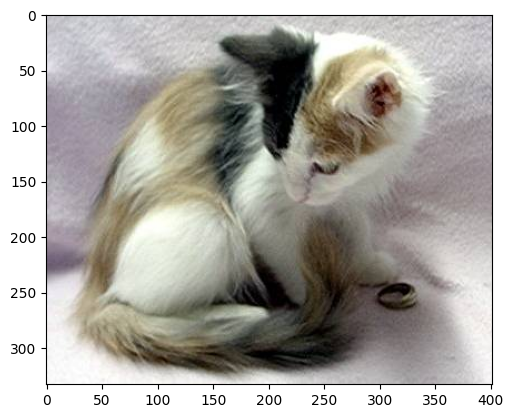

In [40]:
imagem = '/gato/cat.3500.jpg'

classificar_imagem(imagem)

Previsão:  0


'cachorro'

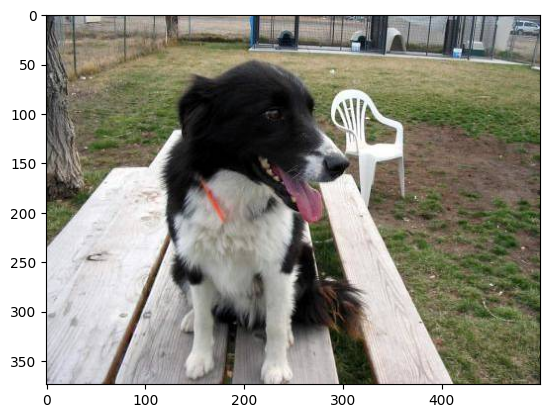

In [41]:
imagem = '/cachorro/dog.3502.jpg'

classificar_imagem(imagem)